# Before the test starts

In this notebook we will explore the typical work you would do when working with a team to plan an A/B test. 

All data needed can be found in the directory `data/`. 

First, let's load all necessary libraries and the data. 

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(14, 8)})

In [2]:
sessions = pd.read_csv("../data/pre_sessions.csv", parse_dates=['visit_started_at'])
cart_visits = pd.read_csv("../data/pre_cart_visits.csv", parse_dates=['cart_accessed_at'])
purchases = pd.read_csv("../data/pre_purchases.csv", parse_dates=['purchase_processed_at'])

In [3]:
print(f"sessions size: {len(sessions):,} \ncart_visits size: {len(cart_visits):,}\npurchases size: {len(purchases):,} ")

sessions size: 50,000 
cart_visits size: 15,000
purchases size: 12,000 


In [4]:
## Explore the tables. Do they have a common key to be joined on?

## Task 1: Help the Product Manager decide on a key decision metric.

- Where are we at right now on the different metrics?
- Which one do we expect to move the most and by how much?
- What would be the material impact of each? $$$

**How many visitors do we get per day, in general?**
- Visualize unique sessions over time
- What countries are they from? What platforms?

Keep only the data that is relevant to our experiment (IT, ES, Mobile apps)

In [5]:
df = sessions.merge(cart_visits, 
                    how='left', 
                    on=['session_id', 'user_id']).merge(purchases, 
                                                        how='left', 
                                                        on=['session_id', 'user_id'])

In [6]:
def clean_platform(platform:str):
    """Returns whether a user is on Android, iOS or any kind of Desktop"""
    if 'Android' in platform:
        return 'android'
    if ('iPad' in platform) or ('iPhone' in platform):
        return 'ios'
    else:
        return 'desktop-other'

In [7]:
df['platform_clean'] = df.platform.apply(lambda x: clean_platform(x))

<AxesSubplot:xlabel='visit_started_at', ylabel='session_id'>

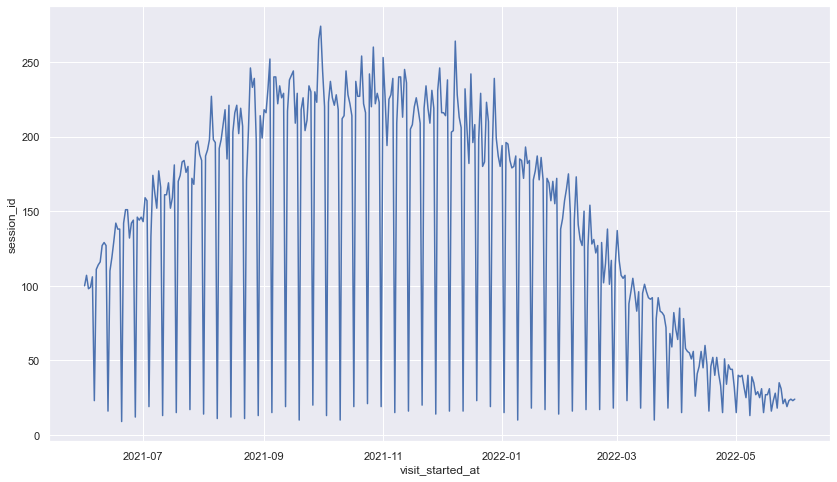

In [24]:
by_date = df.groupby([df.visit_started_at.dt.date]).session_id.nunique()
sns.lineplot(data=by_date)

<AxesSubplot:xlabel='visit_started_at'>

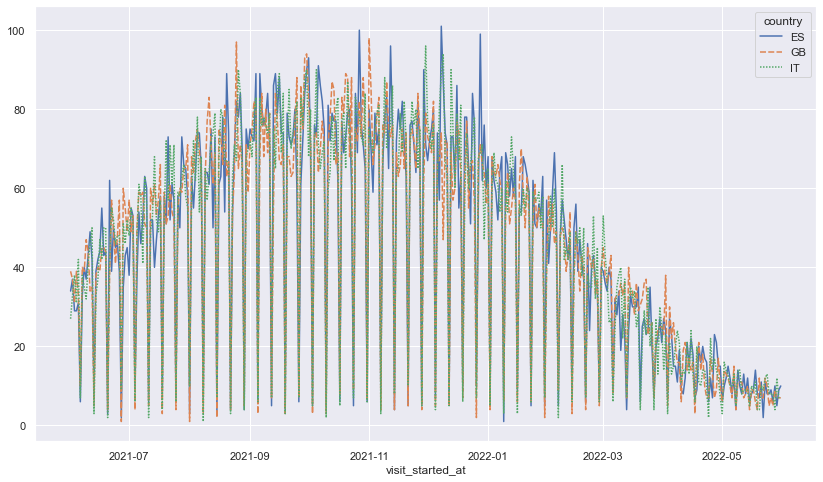

In [18]:
by_date_country = df.groupby([df.visit_started_at.dt.date, df.country]).session_id.nunique().unstack()
sns.lineplot(data=by_date_country)

In [19]:
daily_visitors = df.groupby([df.visit_started_at.dt.date]).session_id.nunique().mean()
print(f"On an average day, we have {daily_visitors:.2f} visitors")

On an average day, we have 136.95 visitors


**How many make it to the cart?**
- Describe the cart state in general
    - What country are the cart visitors from?
    - What devices do they come from?
    - What is the typical basket volume, value?

<AxesSubplot:xlabel='visit_started_at'>

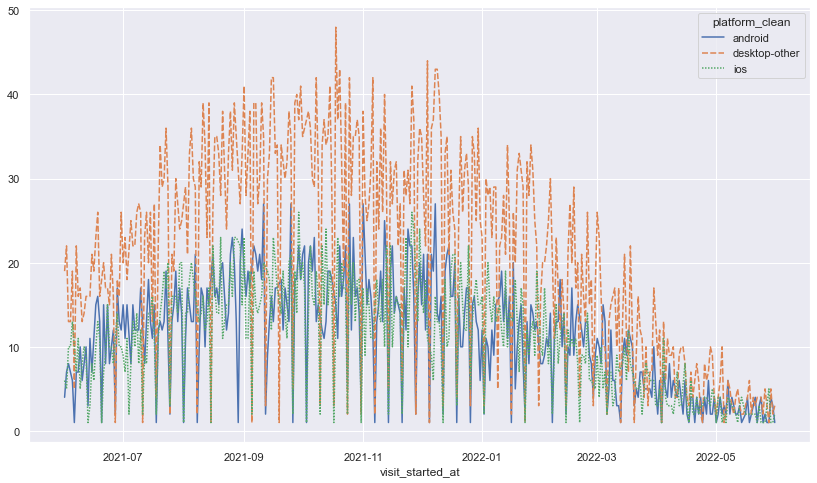

In [21]:
## Don't use the subset yet! Let's look in general still

by_date_platform = df[~df.cart_accessed_at.isna()]\
                        .groupby([df.visit_started_at.dt.date, 'platform_clean'])\
                        .session_id\
                        .nunique()\
                        .unstack()
sns.lineplot(data=by_date_platform)

<AxesSubplot:xlabel='visit_started_at'>

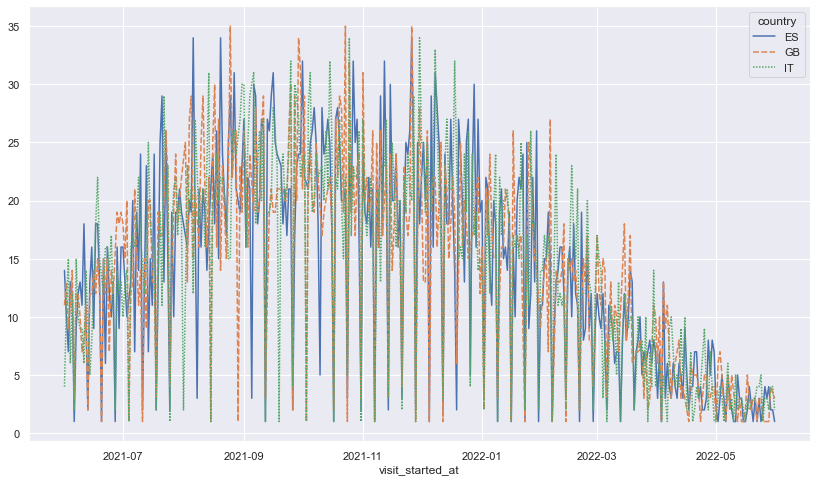

In [25]:
by_date_country = df[~df.cart_accessed_at.isna()]\
                        .groupby([df.visit_started_at.dt.date, 'country'])\
                        .session_id\
                        .nunique()\
                        .unstack()
sns.lineplot(data=by_date_country)

<AxesSubplot:xlabel='visit_started_at'>

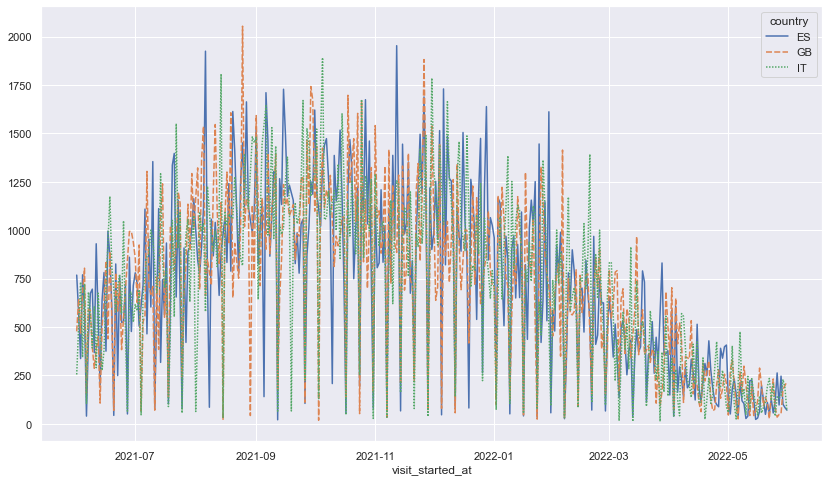

In [26]:
by_date_country_sum_cart = df[~df.cart_accessed_at.isna()]\
                        .groupby([df.visit_started_at.dt.date, 'country'])\
                        .cart_size_eur.sum()\
                        .unstack()
sns.lineplot(data=by_date_country_sum_cart)

In [27]:
df[~df.cart_accessed_at.isna()]\
    .groupby(['country', 'platform_clean'])[['session_id', 'cart_size_eur']]\
    .agg({'session_id': ['count'],
          'cart_size_eur': ['mean', 'std']})

session_id cart_size_eur           
                            count          mean        std
country platform_clean                                    
ES      android              1321     50.303759  22.253552
        desktop-other        2550     50.090721  22.350062
        ios                  1257     49.923580  22.229948
GB      android              1269     50.203927  22.544378
        desktop-other        2492     50.133859  22.485874
        ios                  1252     50.272705  22.265894
IT      android              1373     49.879024  21.470022
        desktop-other        2466     50.140148  23.001083
        ios                  1261     50.570006  23.356623

**How many of them are repeat, how many new?**
- Look at `last_purchase` column to determine if the user is new or old

In [28]:
df['new_repeat'] = df['last_purchase'].apply(lambda x: 'new' if pd.isna(x) else 'repeat')

<AxesSubplot:xlabel='visit_started_at'>

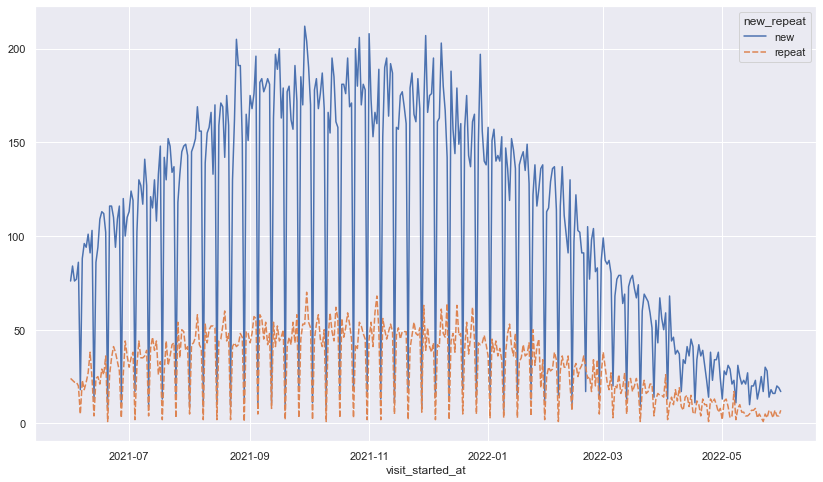

In [29]:
by_date_new_repeat = df.groupby([df.visit_started_at.dt.date, 'new_repeat'])['session_id']\
                       .nunique()\
                       .unstack()
sns.lineplot(data=by_date_new_repeat)

<AxesSubplot:xlabel='new_repeat'>

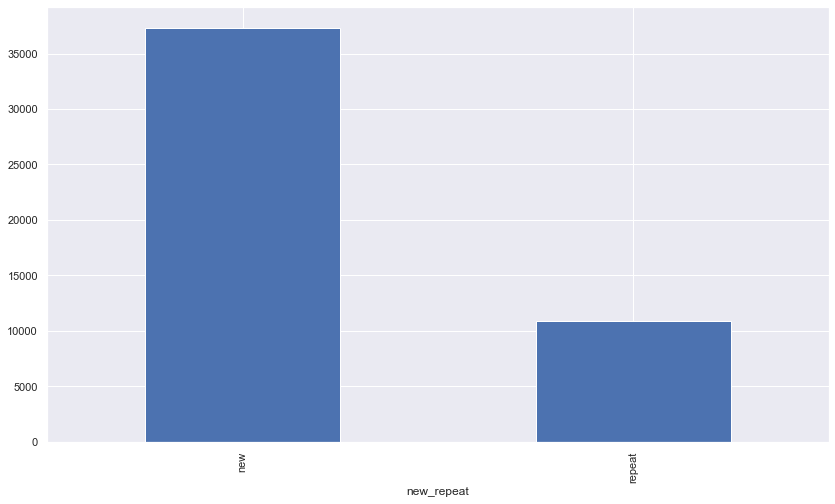

In [30]:
df.groupby('new_repeat')['session_id'].nunique().plot(kind='bar')

**What is the cart conversion rate?**
- Does it differ by platform or payment methods used?
- What is the payment error rate?

Hint: look at the `success` column

In [31]:
# Calculate a column for conversion rate to purchase for those that accessed the cart
df['converted'] = ~df.cart_accessed_at.isna() & ~df.purchase_processed_at.isna()

In [32]:
# Calculate a column for conversation rate to successful purchase for those that accessed the cart
df['converted_success'] = (df.converted) & (df.status=='success')

In [33]:
df[~df.cart_accessed_at.isna()][['converted', 'converted_success']].agg(['mean', 'std'])

,converted,converted_success
mean,0.802113,0.681714
std,0.398420,0.465827


In [34]:
df[~df.cart_accessed_at.isna()].groupby('platform_clean')[['converted', 'converted_success']].agg(['mean', 'std'])

converted           converted_success          
                    mean       std              mean       std
platform_clean                                                
android         0.797880  0.401632          0.679283  0.466811
desktop-other   0.799947  0.400067          0.675812  0.468102
ios             0.810875  0.391660          0.696021  0.460035

In [35]:
df[df.converted]\
    .assign(was_error = lambda x: x.status=='error')\
    .groupby('platform_clean')['was_error']\
    .agg(['mean', 'std'])

,mean,std
platform_clean,,
android,0.063251,0.243453
desktop-other,0.060273,0.238012
ios,0.054302,0.226649


In [36]:
df[df.converted].assign(was_error = lambda x: x.status=='error').groupby('payment_method_selected')['was_error'].agg(['mean', 'std'])

,mean,std
payment_method_selected,,
Giropay,0.055766,0.229532
PayPal,0.061333,0.239986
bank_transfer,0.065929,0.248215
debit_credit_card,0.057486,0.232789


**What are some metrics that could be useful to evaluate adding a new payment method?**
- Think of the action that we want to drive or the problem that we need to solve. 

_________

Now we can finally just use the relevant data (`subset`). Calculate and visualize over time: 
- Visit > payment rate
- Visit > successful payment rate
- Cart visit > payment rate
- Cart visit > successful payment rate
- Average order volume (cart size) processed (purchased)
- % of purchases that fail (`status`="error")

**Thought exercise: what do you think could be a reasonable effects size for each of the above?**

In [40]:
subset = df[(df.country.isin(['IT', 'ES'])) & (df.platform_clean.isin(['ios', 'android']))]
subset.shape

(16818, 19)

In [41]:
# Visit > payment rate and visit > successful payment rate
visit_to_payment_rate_over_time = subset\
                                    .groupby(subset.visit_started_at.dt.date)[['converted', 'converted_success']]\
                                    .mean()

In [42]:
visit_to_payment_rate_over_time

,converted,converted_success
visit_started_at,,
2021-06-01,0.230769,0.230769
2021-06-02,0.121212,0.121212
2021-06-03,0.344828,0.344828
2021-06-04,0.300000,0.300000
2021-06-05,0.285714,0.261905
...,...,...
2022-05-27,0.375000,0.125000
2022-05-28,0.363636,0.363636
2022-05-29,0.153846,0.153846


In [43]:
# Cart visit > payment rate and Cart visit > successful payment rate

cart_visit_to_payment_rate_over_time = subset[~subset.cart_accessed_at.isna()]\
                                            .groupby(subset[~subset.cart_accessed_at.isna()].visit_started_at.dt.date)\
                                            [['converted', 'converted_success']]\
                                            .mean()
cart_visit_to_payment_rate_over_time

,converted,converted_success
visit_started_at,,
2021-06-01,0.857143,0.857143
2021-06-02,0.800000,0.800000
2021-06-03,0.833333,0.833333
2021-06-04,0.818182,0.818182
2021-06-05,0.800000,0.733333
...,...,...
2022-05-26,0.666667,0.666667
2022-05-27,1.000000,0.333333
2022-05-28,0.800000,0.800000


In [44]:
cart_visit_to_payment_rate = subset[~subset.cart_accessed_at.isna()][['converted', 'converted_success']].mean()
cart_visit_to_payment_rate

converted            0.800077
converted_success    0.686685
dtype: float64

In [45]:
# Average order volume processed
avg_order_size_over_time = subset[~subset.cart_accessed_at.isna()]\
                                .groupby(subset[~subset.cart_accessed_at.isna()].visit_started_at.dt.date)\
                                ['cart_size_eur']\
                                .mean()
avg_order_size_over_time

visit_started_at
2021-06-01    56.435824
2021-06-02    43.476252
2021-06-03    37.578496
2021-06-04    60.743523
2021-06-05    62.365711
                ...    
2022-05-26    56.455347
2022-05-27    31.027351
2022-05-28    63.161951
2022-05-29    66.023767
2022-05-30    42.453153
Name: cart_size_eur, Length: 351, dtype: float64

## Task 2: Determine how long the test will need to be run for

Now that we've explored some possible metrics, let's try to estimate how many samples we would need in order to detect the desired effect size in each. For simplicity, let's assume that you are still debating between using as the **primary decision metric**: 

- Visit > payment rate
- Cart visit > successful payment rate

**Thought exercise: What are the pros and cons of each?**

**Visit > payment rate**

Pros:

- just `visit` has a lot more traffic than `cart_visit`
- might be more closely related to high-level metrics tracked by the business, such as "visit > sale"

Cons:

- the baseline conversion rate is quite small, so it will be harder to detect the same effect size as with a metric where the conversion rate is higher
- the actual experiment is implemented on the payment page / cart, so you should see no impact at all on visit > cart (unless it's advertised earlier in the funnel), effectively watering down the results  of the specific experiment. 
- does not take into account if the actual payment failed, only that the user attemped to make a payment

**Cart visit > successful payment rate**

Pros: 

- directly measures what the experiment is trying to capture: "does adding a new payment method make people more likely to successfully purchase?"
- baseline conversion will be higher than if you were starting from `visit`, which means you need fewer samples to detect the same effect size. 
- accounts for errors or failures of the existing payment methods

Cons: 

- the `cart_visit` volume will be lower, so you need to balance that out with the conversion rate. 
- does not directly translate to the high-level business metrics (such as "visit > sale") 

**Define your inputs**

TODO ADD schematic

In [47]:
subset.head()

,session_id,user_id,name,country,platform,ip_address,visit_started_at,last_purchase,cart_size_eur,num_items,cart_accessed_at,expanded_payment_methods,payment_method_selected,status,purchase_processed_at,platform_clean,new_repeat,converted,converted_success
0,bf42fc3aefdd5784b29c409430099030,d296ce0732867cd124e5f625e7f0ba64,Gianfrancesco Morpurgo,IT,Android 7.0,74.38.249.30,2021-06-22 17:00:00,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,android,new,False,False
2,55e685cd19a3103ed2a9a5aa98921ebf,36dcc4894875aabb4c5fc95c85069cd6,Augusto del Campos,IT,Android 9,49.57.132.115,2021-10-01 07:00:00,2021-02-16 06:52:13.097027,NaN,NaN,NaT,NaN,NaN,NaN,NaT,android,repeat,False,False
5,379f52bd45e77a8728463c76c7a3da70,64deb92c7a959721722d9e3404dc4bfa,Nanni Volterra,ES,Android 2.0.1,213.83.46.14,2021-12-20 14:00:00,2020-12-21 13:08:05.309464,41.791366,1.0,2021-12-20 14:14:17.614685,False,debit_credit_card,success,2021-12-20 14:14:43.711457,android,repeat,True,True
6,d6f0c366e246cefaa09718a6125d3633,ba48023b07979f3485a8827a0f403a62,Felipe Rius Seco,ES,iPhone; CPU iPhone OS 9_3_6 like Mac OS X,93.179.111.154,2022-01-01 22:00:00,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,ios,new,False,False
8,867ffc1e3d97291b589465b2534c020e,c1f675e26d8993f26517bb950ea51937,Adele Liguori,ES,Android 11,55.239.80.42,2022-02-19 14:00:00,NaN,63.948269,1.0,2022-02-19 14:15:18.136523,True,Giropay,rejected,2022-02-19 14:14:16.269939,android,new,True,False


In [126]:
power = 0.8
alpha = 0.05
p_1 = subset['converted'].mean()
p_2 = subset[~subset.cart_accessed_at.isna()]['converted_success'].mean()

rel_effect_sizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]

**What is a reasonable daily average traffic to assume?**
- Hint: the T-test assumes that observations are independent of each other. But what if a user comes in multiple times?

In [129]:
# Calculate average daily traffic for Visit > payment rate metric
traffic_1 = subset.groupby(subset.visit_started_at.dt.date)\
                  .session_id\
                  .nunique()\
                  .mean()

# Calculate average daily traffic for Cart visit > successful payment rate metric
traffic_2 = subset[~subset.cart_accessed_at.isna()]\
                    .groupby(subset.visit_started_at.dt.date)\
                    .session_id\
                    .nunique()\
                    .mean()

In [130]:
print(f"Visit > payment has a baseline of {p_1:.2%} and there are {traffic_1:.2f} visits per day")
print(f"Cart visit > successful payment has a baseline of {p_2:.2%} and there are {traffic_2:.2f} visits per day")

Visit > payment has a baseline of 24.79% and there are 46.10 visits per day
Cart visit > successful payment has a baseline of 68.67% and there are 14.75 visits per day


**What is the number of observations you need to measure effect size Delta, for each of the metrics?**

Here we will finally use `statsmodels` to calculate the desired effect size. 

We will use [`statsmodels.stats.power.tt_ind_solve_power`](https://www.statsmodels.org/dev/generated/statsmodels.stats.power.tt_ind_solve_power.html), which is a pretty neat method in `statsmodels` that outputs whatever is missing from the following: 
- alpha
- power
- n observations
- standardized_effect_size

Note that the effect size has to be expressed as: "difference between the two means divided by the standard deviation". In the case of the binomial distribution (which is the case here), the standard deviation is equal to `sqrt(p*(1-p))`. We will write a custom function to help us with that transformation. 

In [131]:
from statsmodels.stats.power import tt_ind_solve_power
import math

In [132]:
def get_effect_size_proportions(diff: float, p:float):
    """Gets appropriately transformed effect size for proportions. This means
    absolute difference between the two means divided by the standard deviation"""
    return abs(diff)/math.sqrt(p*(1-p))

In [133]:
def calculate_power_table(p_baseline:float, 
                          rel_effect_sizes: list, 
                          daily_visitors:float, 
                          power:float=0.8, 
                          alpha:float=0.05):
    """Generates a table showing the expected duration of the experiment for different effect sizes,
    given an provided daily traffic rate. Assumes traffic remains constant over the duration of the
    experiment."""
    abs_effect_sizes = [p_baseline*(1+i) - p_baseline for i in rel_effect_sizes]
    transformed_effect_sizes = [get_effect_size_proportions(e, p_baseline) for e in abs_effect_sizes]
    
    sample_sizes = [round(tt_ind_solve_power(effect_size=e, 
                                       alpha=alpha, 
                                       power=power, 
                                       alternative='two-sided'), 2) for e in transformed_effect_sizes]
    durations_days = [round(s / daily_visitors, 2) for s in sample_sizes]
    durations_weeks = [round(d / 7, 2) for d in durations_days]
    
    return pd.DataFrame({'baseline': p_baseline,
                         'rel_effect_size': rel_effect_sizes,
                         'abs_effect_size': abs_effect_sizes,
                         'alpha': alpha,
                         'power': power,
                         'sample_size_required': sample_sizes,
                         'days_required': durations_days,
                         'weeks_required': durations_weeks})
    

In [134]:
# print table for Visit > payment rate
calculate_power_table(p_baseline=p_1,
                      rel_effect_sizes=rel_effect_sizes,
                      daily_visitors=traffic_1,
                      power=power,
                      alpha=alpha)

,baseline,rel_effect_size,abs_effect_size,alpha,power,sample_size_required,days_required,weeks_required
0,0.247949,0.01,0.002479,0.05,0.8,476127.53,10327.16,1475.31
1,0.247949,0.02,0.004959,0.05,0.8,119032.60,2581.81,368.83
2,0.247949,0.05,0.012397,0.05,0.8,19046.02,413.11,59.02
3,0.247949,0.10,0.024795,0.05,0.8,4762.23,103.29,14.76
4,0.247949,0.20,0.049590,0.05,0.8,1191.28,25.84,3.69
5,0.247949,0.30,0.074385,0.05,0.8,529.99,11.50,1.64
6,0.247949,0.50,0.123974,0.05,0.8,191.42,4.15,0.59


In [135]:
# print table Cart visit > successful payment rate
calculate_power_table(p_baseline=p_2,
                      rel_effect_sizes=rel_effect_sizes,
                      daily_visitors=traffic_2,
                      power=power,
                      alpha=alpha)

,baseline,rel_effect_size,abs_effect_size,alpha,power,sample_size_required,days_required,weeks_required
0,0.686685,0.01,0.006867,0.05,0.8,71625.38,4857.13,693.88
1,0.686685,0.02,0.013734,0.05,0.8,17907.06,1214.33,173.48
2,0.686685,0.05,0.034334,0.05,0.8,2865.94,194.35,27.76
3,0.686685,0.10,0.068668,0.05,0.8,717.21,48.64,6.95
4,0.686685,0.20,0.137337,0.05,0.8,180.03,12.21,1.74
5,0.686685,0.30,0.206005,0.05,0.8,80.55,5.46,0.78
6,0.686685,0.50,0.343342,0.05,0.8,29.64,2.01,0.29


**Put it all together**

Based on the discussion above, what would you recommend?

- There is no black or white answer here.
- Personally, I would lean more towards the `Cart visit > successful payment rate` metric as the primary decision metric for the experiment, as this is the behaviour we want to directly influence through this experiment. 
- We can always use the other metrics as secondary or supportive metrics. You can read more about how Optimizely, one of the most popular experimentation SaaS platforms, suggests you define primary and secondary metrics and monitoring goals ("do no harm"): [Primary and secondary metrics and monitoring goals](https://support.optimizely.com/hc/en-us/articles/4410283160205-Primary-and-secondary-metrics-and-monitoring-goals) 

## Task 3: Finalize the experiment plan

Here, simply write down what you are going to propose to the product manager. 

- Experiment name: 
- Hypothesis formulation:
- Platform: 
- Users targeted:
- Primary decision metric:
- Baseline of this metric in the last {} months:
- Expected effect size (relative): 
- Expected experiment duration: 